In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('data/train.csv',dtype={'Age':np.float64})
test = pd.read_csv('data/test.csv',dtype={'Age':np.float64})
PassengerId = test['PassengerId']
all_data = pd.concat([train,test],ignore_index=True)

Percentage of females who survived:74.20
Percentage of males who survived:18.89


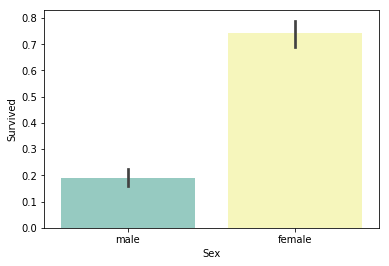

In [9]:
# 1、数据可视化
# 1)Sex Feature: 女性幸存率远高于男性
sns.barplot(x='Sex',y='Survived',data=train,palette='Set3')
print('Percentage of females who survived:%.2f' % (train['Survived'][train['Sex'] == 'female'].value_counts(normalize=True)[1]*100))
print('Percentage of males who survived:%.2f'% (train['Survived'][train['Sex']=='male'].value_counts(normalize=True)[1]*100))

Percentage of Pclass =1 who survived:62.96
Percentage of Pclass =2 who survived:47.28
Percentage of Pclass =3 who survived:24.24


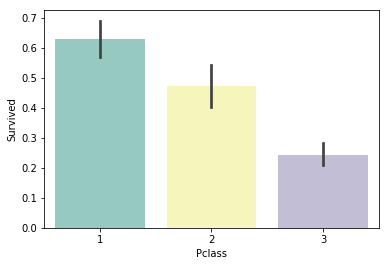

In [10]:
# 2)Pclass Feature:乘客社会等级越高，幸存率越高
sns.barplot(x='Pclass',y='Survived',data=train,palette='Set3')
print('Percentage of Pclass =1 who survived:%.2f' % (train['Survived'][train['Pclass']==1].value_counts(normalize=True)[1]*100))
print('Percentage of Pclass =2 who survived:%.2f' % (train['Survived'][train['Pclass']==2].value_counts(normalize=True)[1]*100))
print('Percentage of Pclass =3 who survived:%.2f' % (train['Survived'][train['Pclass']==3].value_counts(normalize=True)[1]*100))


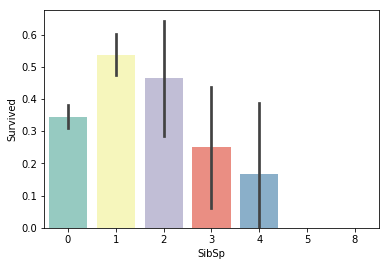

In [11]:
# 3)SibSp Feature: 配偶及兄弟姐妹数适中的乘客幸存率更高
sns.barplot(x='SibSp',y='Survived',data=train,palette='Set3')

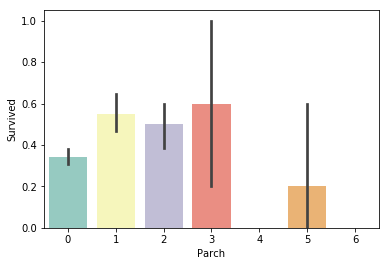

In [12]:
# 4)Parch Feature:父母与子女数适中的乘客幸存率更高
sns.barplot(x='Parch',y='Survived',data=train,palette='Set3')

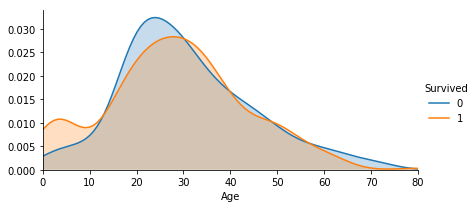

In [14]:
# 5)Age Feature:未成年人幸存率高于成年人

facet = sns.FacetGrid(train,hue='Survived',aspect=2)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0,train['Age'].max()))
facet.add_legend()

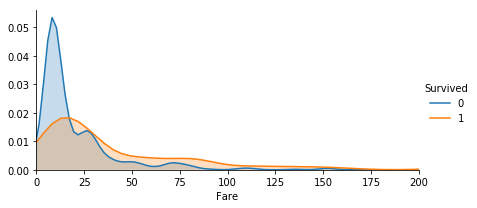

In [15]:
# 6)Fare Feature:支出船票费越高幸存率越高
facet = sns.FacetGrid(train,hue='Survived',aspect=2)
facet.map(sns.kdeplot,'Fare',shade=True)
facet.set(xlim=(0,200))
facet.add_legend()

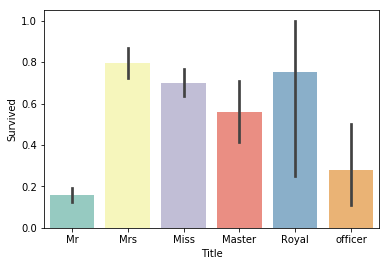

In [18]:
# 7)Title Feature(New):不同称呼的乘客幸存率不同
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt','Col','Major','Dr','Rev'],'officer'))
Title_Dict.update(dict.fromkeys(['Don','Sir','the Countess','Dona','Lady'],'Royal'))
Title_Dict.update(dict.fromkeys(['Mme','Ms','Mrs'],'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle','Miss'],'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'],'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'],'Master'))
all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x='Title',y='Survived',data=all_data,palette='Set3')

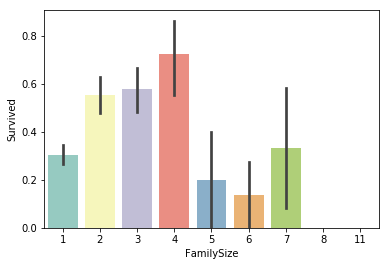

In [19]:
# 8)FamilyLabel Feature(New):家庭人数为2到4的乘客幸存率较高
#FamilySize = Parch + SibSp + 1
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
sns.barplot(x='FamilySize',y='Survived',data=all_data,palette='Set3')

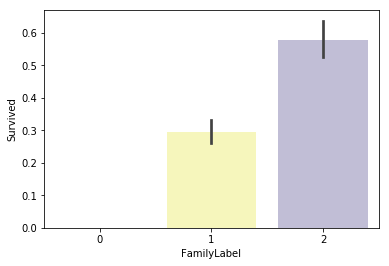

In [21]:
# 按照生存率把FamilySize分为三类，构成FamilyLabel特征
def Fam_label(s):
    if (s>=2) & (s<=4):
        return 2
    elif ((s>4) & (s<=7)) | (s==1):
        return 1
    elif s>7:
        return 0

all_data['FamilyLabel'] = all_data['FamilySize'].apply(Fam_label)
sns.barplot(x='FamilyLabel',y='Survived',data=all_data,palette='Set3')

In [22]:
# 10)TicketGroup Feature(New):与2至4人共票号的乘客幸存率较高
# 新增TicketGroup特征，统计每个乘客的共票号数
Ticket_Count = dict(all_data['Ticket'].value_counts())

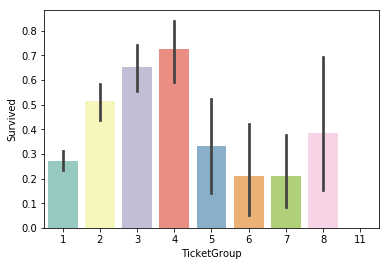

In [23]:
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x: Ticket_Count[x])
sns.barplot(x='TicketGroup',y='Survived',data=all_data,palette='Set3')

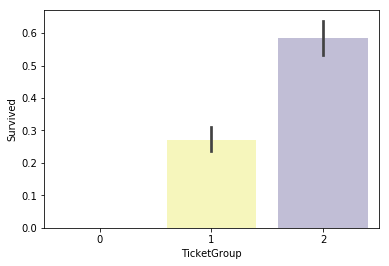

In [26]:
# 按照生存率把TicketGroup分为三类：
def Ticket_Label(s):
    if (s>=2) & (s<=4):
        return 2
    elif ((s>4) & (s<=8)) | (s==1):
        return 1
    elif (s>8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup',y='Survived',data=all_data,palette='Set3')

In [32]:
# 2、数据清洗
# 1）缺失值填充：
# Age Feature:Age缺失量为263，确实量较大，用Sex,Title,Pclass三个特征构建随机森林模型，填充年龄缺失值
age_df = all_data[['Age','Pclass','Sex','Title']]
age_df = pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].values
unknown_age = age_df[age_df.Age.isnull()].values
y=known_age[:,0]
X=known_age[:,1:]
rfr = RandomForestRegressor(random_state=0,n_estimators=100,n_jobs=-1)
rfr.fit(X,y)
predictedAges = rfr.predict(unknown_age[:,1:])
all_data.loc[ (all_data.Age.isnull()),'Age']=predictedAges